# Audio Loading, Preprocessing and Feature Extraction

In this notebook we will go through how to load, process and extract features from audio data.

#1. Loading audio data
Loading audio data is the first step in any speech recognition pipeline.

Audio comes in many formats like MP3, WAV or FLAC. These formats already contain the sampled data, so loading them means reading the series of numbers that represent the audio signal over time. We call this kind of data a time-series representation.

Loading audio correctly is crucial for maintaining the integrity of the data. Errors in loading can introduce noise or distortions that may adversely affect the ASR's performance.

Additionally, understanding the sample rate and the duration of the audio provides valuable information for subsequent processing stages such as feature extraction.



### Download sample data

To begin, let's download some sample audio files.

In [1]:
!curl -L -o free-spoken-digits.zip \
  https://www.kaggle.com/api/v1/datasets/download/alanchn31/free-spoken-digits
!unzip free-spoken-digits.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.7M  100 15.7M    0     0  16.6M      0 --:--:-- --:--:-- --:--:-- 33.7M
Archive:  free-spoken-digits.zip
  inflating: free-spoken-digit-dataset-master/.gitignore  
  inflating: free-spoken-digit-dataset-master/README.md  
  inflating: free-spoken-digit-dataset-master/__init__.py  
  inflating: free-spoken-digit-dataset-master/acquire_data/say_numbers_prompt.py  
  inflating: free-spoken-digit-dataset-master/acquire_data/split_and_label_numbers.py  
  inflating: free-spoken-digit-dataset-master/metadata.py  
  inflating: free-spoken-digit-dataset-master/pip_requirements.txt  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_0.wav  
  inflating: free-spoken-digit-dataset-master/recordings/0_george_1.wav  
  inflating: free-spoken-d

### Loading local audio files

### Using Librosa

In [2]:
!pip install librosa

In [11]:
# Load some audio data with librosa
import librosa

# When using librosa.load, it returns both our audio_data as numbers and the sample rate
audio_data, sample_rate = librosa.load(
    path="free-spoken-digit-dataset-master/recordings/0_george_0.wav",
    sr=None, # Setting sr=None preserves the sample rate of the source file.
)

print("Audio data:", audio_data) # Notice our audio has been converted to an array of numbers
print("Audio duration:", audio_data.shape[0] / sample_rate, "sec")
print("Sample rate:", sample_rate, "Hz")

Audio data: [-0.04544067 -0.02935791 -0.01849365 ... -0.05535889 -0.03387451
 -0.00045776]
Audio duration: 0.298 sec
Sample rate: 8000 Hz


### Using PyTorch

In [12]:
import torch
import torchaudio
import matplotlib.pyplot as plt

def load_audio(file_path):
  waveform, sample_rate = torchaudio.load(file_path)
  print(f"Loaded audio file: {file_path}")

  # Note that PyTorch loads audio files as a 2D array.
  # First dimension is number of channels; second dimension is time.
  # If we were loading a stereo file, waveform.shape[0] would be 2 instead of 1.
  print(f"Waveform shape: {waveform.shape}")

  print(f"Sample rate: {sample_rate} Hz")
  return waveform, sample_rate

file_path = "free-spoken-digit-dataset-master/recordings/0_george_0.wav"
waveform, sample_rate = load_audio(file_path)

Loaded audio file: free-spoken-digit-dataset-master/recordings/0_george_0.wav
Waveform shape: torch.Size([1, 2384])
Sample rate: 8000 Hz


## Loading audio datasets from Hugging Face

In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [13]:
from datasets import load_dataset

# Load a sample from the free spoken digit dataset
dataset = load_dataset('hf-internal-testing/librispeech_asr_dummy', 'clean', split='validation')

audio = dataset[0]['audio']
waveform = torch.tensor(audio['array']).unsqueeze(0)

# Convert waveform data type from float64 to float32 because torchaudio expects inputs in float32.
waveform = waveform.to(torch.float32)

sample_rate = audio['sampling_rate']
print(f'Waveform shape: {waveform.shape}')
print(f'Sample rate: {sample_rate}')

Waveform shape: torch.Size([1, 93680])
Sample rate: 16000


# Visualizing audio data

We can visualize audio waveforms by plotting amplitude against time, as below.

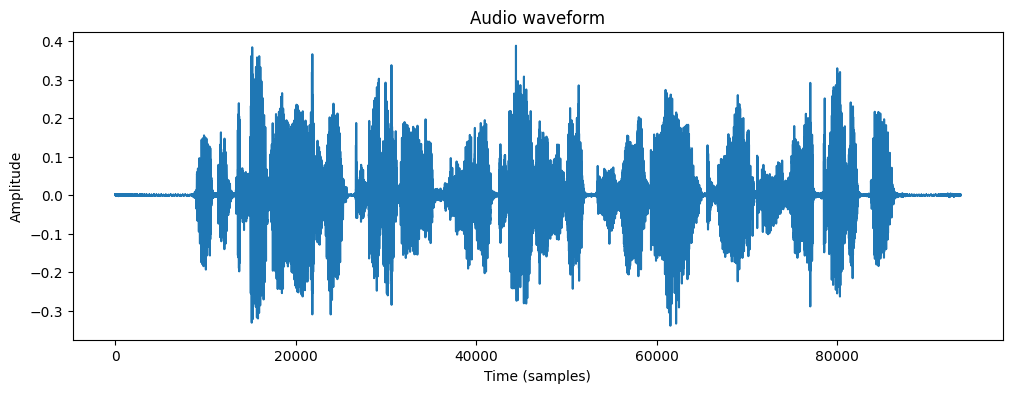

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(waveform[0]) # Plot first channel of waveform
plt.title("Audio waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

# Sampling
Sampling is the process of measuring a continuous audio signal at discrete points in time to convert it into digital form. Each measurement captures the amplitude (intensity) of the sound wave at that precise moment.

## What is sample rate?
Sample rate defines how often a measurement is taken. Common units are hertz (Hz) or kilohertz (kHz). 1 Hz = 1 measurement per second.

## Effect of sample rate
Increasing the sample rate improves how representative the sampled audio is of the orginal data. However, storing and processing audio at higher sample rates require more computational resources. Increasing sample rate also tends to give diminishing returns for ASR.

## Playing around with sample rate

Many audio-processing libraries include functionality to *resample* audio files; i.e. to change their sample rate. Try it below!

Notice how the shape and sound of the waveform remain the same, but the scale of the time axis changes.

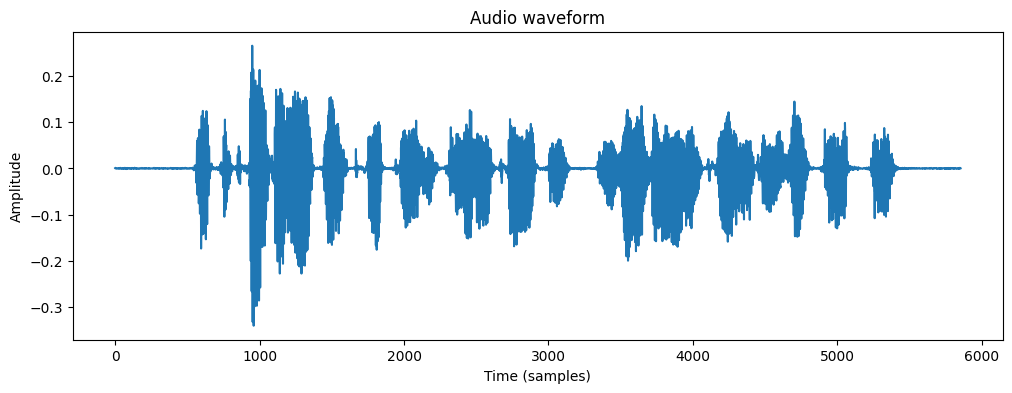

In [16]:
import IPython.display as ipd

new_sample_rate = 1000 # @param {type:"slider", min:1000, max:24000, step:1000}

waveform_resampled = torchaudio.functional.resample(
    waveform, orig_freq=sample_rate, new_freq=new_sample_rate,
)

# Plot audio data
plt.figure(figsize=(12, 4))
plt.plot(waveform_resampled[0])
plt.title("Audio waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

# Display sample
ipd.Audio(waveform_resampled, rate=new_sample_rate)

# 2. Audio preprocessing

Speech recognition systems often require preprocessing in order to achieve high accuracy.

Common preprocessing steps include:
- **Resampling:** Audio is converted to standard sample rate (typically 16 kHz for speech recognition) to ensure consistency across inputs. **This is important**! Most pretrained models are trained on audio with a preset sample rate, so using a different sample rate will hurt accuracy.
- **Conversion to single-channel:** If input audio has more than one channel, it is converted to single-channel, since speech recognition generally doesn't benefit from multi-channel audio.
- **Normalization:** Amplitude of input audio is scaled (typically to a maximum of 1) to ensure consistency.

In [17]:
def preprocess_audio(waveform, new_sample_rate=8000):
  # Resample
  print("Waveform shape before sampling:", waveform.shape)
  waveform = torchaudio.functional.resample(
      waveform, orig_freq=sample_rate, new_freq=new_sample_rate,
  )
  print("Waveform shape after resampling:", waveform.shape)

  # Convert to single-channel
  print("Waveform shape before converting to single-channel:", waveform.shape)
  waveform = waveform.mean(dim=0, keepdim=True)
  print("Waveform shape after converting to single-channel:", waveform.shape)

  # Normalize audio to [-1, 1]
  print(f"Waveform amplitude range before normalization: min={waveform.min()}, max={waveform.max()}")
  waveform = waveform / waveform.abs().max()
  print(f"Waveform amplitude range after normalization: min={waveform.min()}, max={waveform.max()}")

  return waveform

waveform_processed = preprocess_audio(waveform)

Waveform shape before sampling: torch.Size([1, 93680])
Waveform shape after resampling: torch.Size([1, 46840])
Waveform shape before converting to single-channel: torch.Size([1, 46840])
Waveform shape after converting to single-channel: torch.Size([1, 46840])
Waveform amplitude range before normalization: min=-0.31822705268859863, max=0.3798467218875885
Waveform amplitude range after normalization: min=-0.8377775549888611, max=1.0


# Feature extraction


Feature extraction is a crucial step in speech recognition, and in machine learning in general. It transforms raw audio data into a more **compact and representative format** that is easier for ASR models to process.

By training a ASR model on extracted features that contain more meaningful acoustic patterns instead of the raw audio, it learns to recognize speech by analyzing features in the sound.

These are several commonly used features:

- **Spectrogram**: A spectrogram is a visual representation of the frequencies present in a waveform as it varies with time.

- **Mel spectrogram**: Spectrogram converted to the Mel scale, which more closely represents amplitudes of constituent frequencies as perceived by humans.

- **Mel-frequency cepstral coefficients (MFCCs)**: MFCCs are a compact representation of the audio, derived from the Mel spectrogram. Learn more on [Wikipedia](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)!


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


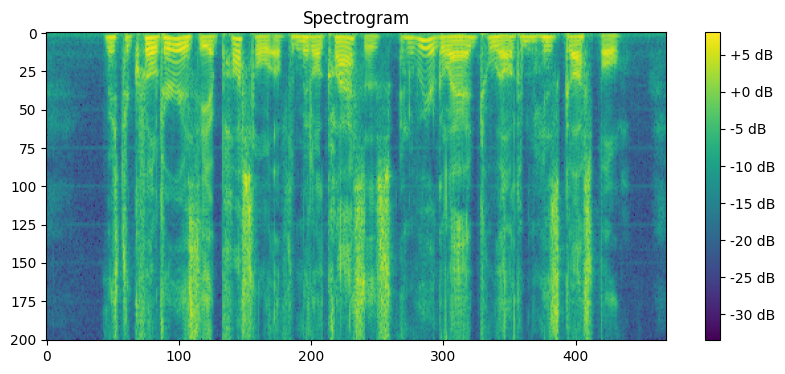

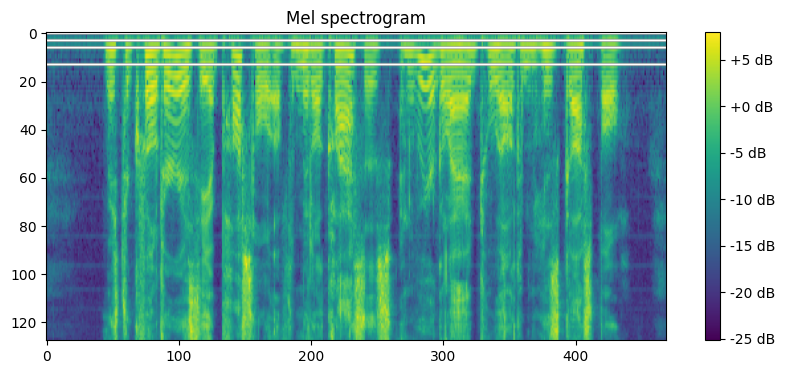

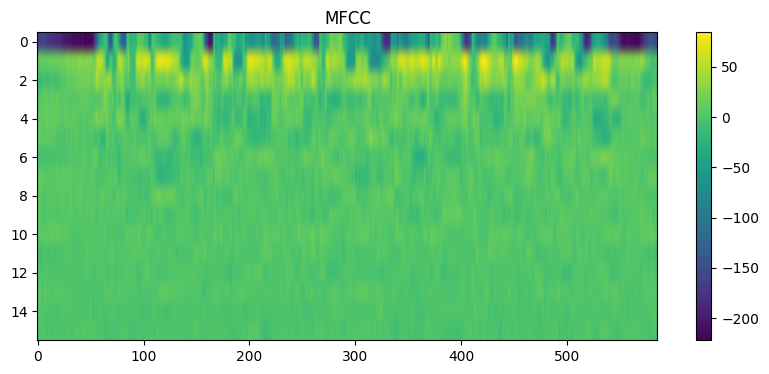

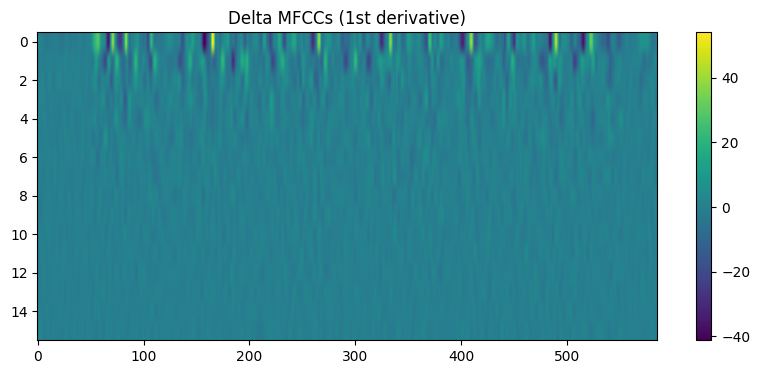

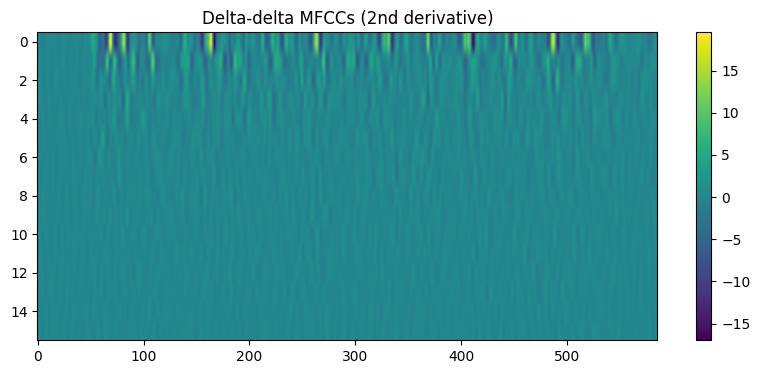

In [18]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torchaudio.functional as F

def extract_features(waveform, sample_rate, n_mfcc):
    # Compute standard spectrogram
    spectrogram_transform = T.Spectrogram()
    spectrogram = spectrogram_transform(waveform)
    # Alternatively:
    # spectrogram = F.spectrogram(waveform)

    # Compute Mel spectrogram
    mel_spectrogram_transform = T.MelSpectrogram(sample_rate=sample_rate)
    mel_spectrogram = mel_spectrogram_transform(waveform)

    # Compute MFCCs from mel spectrogram
    # n_mfcc controls how many features are extracted from the MFCC feature extractor.
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23})
    mfccs = mfcc_transform(waveform)

    # Compute delta (1st derivative) of MFCCs
    delta_mfccs = F.compute_deltas(mfccs)

    # Compute delta-delta (2nd derivative) of MFCCs
    delta2_mfccs = F.compute_deltas(delta_mfccs)

    return spectrogram, mel_spectrogram, mfccs, delta_mfccs, delta2_mfccs

# Example usage (assuming 'waveform' and 'sample_rate' are already defined)
spectrogram, mel_spectrogram, mfccs, delta_mfccs, delta2_mfccs = extract_features(
    waveform, sample_rate=16000, n_mfcc=16,
)

# Plot standard spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram.log2()[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.log2()[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Mel spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(mfccs[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('MFCC')
plt.colorbar()
plt.show()

# Plot delta MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(delta_mfccs[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Delta MFCCs (1st derivative)')
plt.colorbar()
plt.show()

# Plot delta-delta MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(delta2_mfccs[0].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Delta-delta MFCCs (2nd derivative)')
plt.colorbar()
plt.show()